# Image Inpainting

### Team Members: Aakansha Bhatt, Anika Tabassum, Sadia Mahtaban

##### REF: https://github.com/ayulockin/deepimageinpainting

### Loading TensorFlow and other functions

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils
import cv2
from itertools import product

2.5.0


### Loading Dataset

170508288/170498071 [==============================] - 6s 0us/step
Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


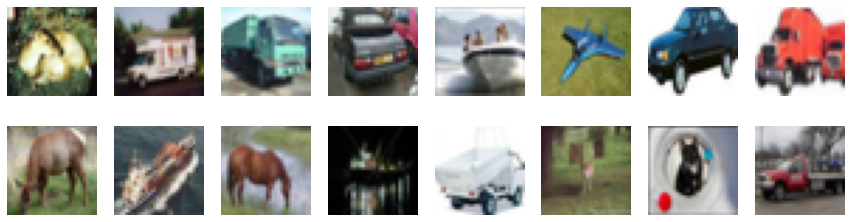

In [ ]:
from keras.datasets import cifar10

# Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

# show images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2*cols-1, 2.5*rows-1))

for i,j in product(range(cols), range(rows)):
    index = np.random.randint(0, len(y_train))
    ax = fig.add_subplot(rows, cols, i * rows + j + 1)
    ax.axis('off')
    ax.imshow(x_train[index,:])

plt.show()

### Data Generation and Masking

Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:
class GenerateMask(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        # creating mask
        mask = np.full((32,32,3), 255, np.uint8)
        for _ in range(np.random.randint(1, 10)):
          # Get random x locations to start line
          x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
          # Get random y locations to start line
          y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
          # Get random thickness of the line drawn
          thickness = np.random.randint(1, 3)
          # Draw black line on the white mask
          cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

        # Perforn bitwise and operation to mak the image
        masked_image = cv2.bitwise_and(tmp_image, mask)

        # Normalizing data
        X_batch[i,] = masked_image/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

In [ ]:
traingen = GenerateMask(x_train, x_train)
testgen = GenerateMask(x_test, x_test)

print("Traingen samples:", len(traingen))
print("Testgen samples:", len(testgen))

Traingen samples: 1562
Testgen samples: 312


### Displaying Original and Masked Images

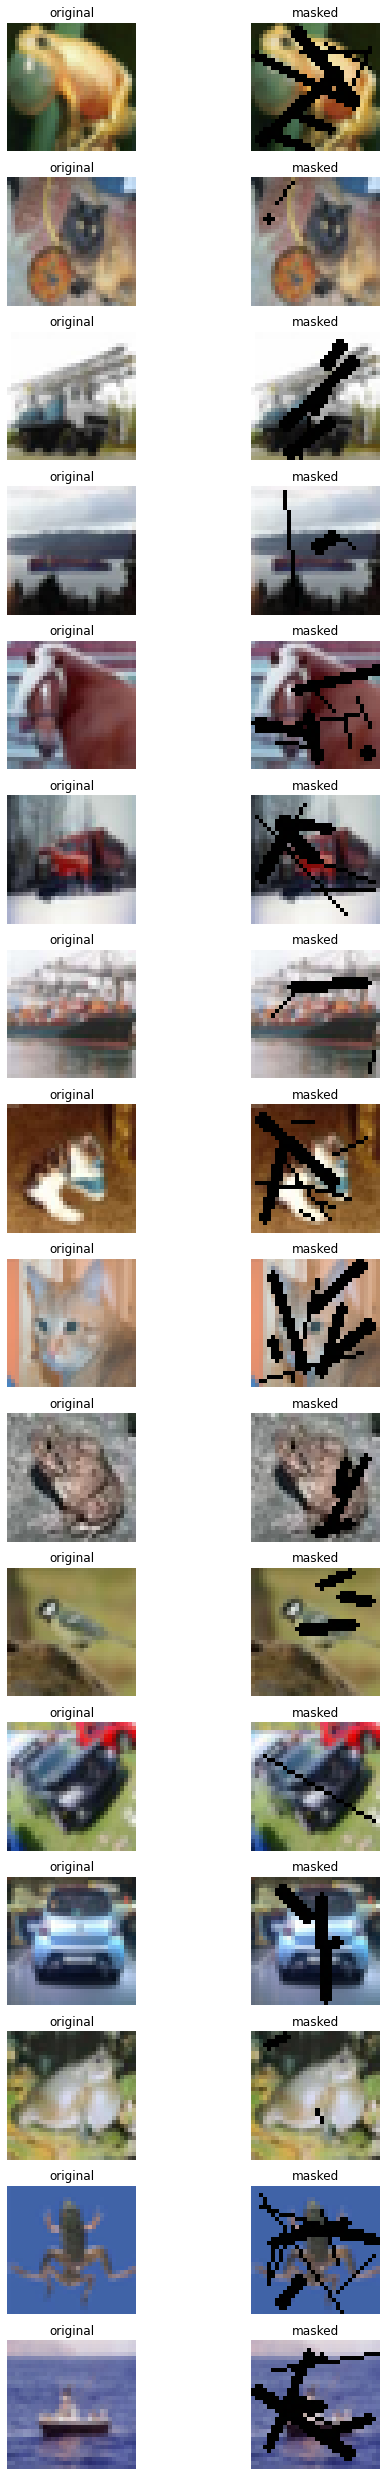

In [ ]:
# display images
rows = 16
index = np.random.randint(0, len(traingen), rows)

fig, ax = plt.subplots(nrows=16, ncols=2, figsize=(8,45))

for i, index in enumerate(index):
  
  sample_images, sample_labels = traingen[index]
  image_index = np.random.randint(0, len(sample_images)-1, 1)[0]
  
  ax[i][0].imshow(sample_labels[image_index])
  ax[i][0].set_title('original')
  ax[i][0].axis('off')
  
  ax[i][1].imshow(sample_images[image_index])
  ax[i][1].set_title('masked')
  ax[i][1].axis('off')

plt.show()

### Creating Inpainting Model

In [ ]:
def inpainting_model():

  # image size 32x32, 3 color channels
  input = keras.layers.Input((32, 32, 3))

  # 32 filters, with kernal size 3x3
  conv0 = (keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))(input)
  conv1 = (keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))(conv0)
  
  pool0 = (keras.layers.MaxPooling2D(pool_size=(2,2)))(conv1)

  conv2 = (keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))(pool0)
  conv3 = (keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))(conv2)
  
  pool1 = (keras.layers.MaxPooling2D(pool_size=(2,2)))(conv3)

  conv4 = (keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))(pool1)
  conv5 = (keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))(conv4)
  
  pool2 = (keras.layers.MaxPooling2D(pool_size=(2,2)))(conv5)

  conv6 = (keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))(pool2)
  conv7 = (keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))(conv6)
  
  pool3 = (keras.layers.MaxPooling2D(pool_size=(2,2)))(conv7)

  conv8 = (keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'))(pool3)
  conv9 = (keras.layers.Conv2D(512, (3,3), padding='same', activation='relu'))(conv8)
  
  conv_transpose0 = (keras.layers.Conv2DTranspose(256, (2,2), strides=(2, 2), padding='same'))(conv9)
  concatenate0 = keras.layers.concatenate([conv_transpose0, conv7])

  conv10 = (keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))(concatenate0)
  conv11 = (keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))(conv10)

  conv_transpose1 = (keras.layers.Conv2DTranspose(128, (2,2),strides=(2, 2), padding='same'))(conv11)
  concatenate1 = keras.layers.concatenate([conv_transpose1, conv5])

  conv12 = (keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))(concatenate1)
  conv13 = (keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))(conv12)

  conv_transpose2 = (keras.layers.Conv2DTranspose(64, (2,2),strides=(2, 2), padding='same'))(conv13)
  concatenate2 = keras.layers.concatenate([conv_transpose2, conv3])

  conv14 = (keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))(concatenate2)
  conv15 = (keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))(conv14)

  conv_transpose3 = (keras.layers.Conv2DTranspose(32, (2,2),strides=(2, 2), padding='same'))(conv15)
  concatenate3 = keras.layers.concatenate([conv_transpose3, conv1])

  conv16 = (keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))(concatenate3)
  conv17 = (keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))(conv16)

  output = (keras.layers.Conv2D(3, (3,3), padding='same', activation='sigmoid'))(conv17)

  return keras.models.Model(inputs=[input], outputs=[output])

### Defining the metrics for compiling the model


In [ ]:
# defining SSIM metric function
def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

### Compiling Inpainting Model

In [ ]:
keras.backend.clear_session()
model = inpainting_model()
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Training Model

In [ ]:
EPOCHS = 10

# fit model
model.fit(traingen, validation_data=testgen, 
          epochs=EPOCHS, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/10
1562/1562 [==============================] - 44s 27ms/step - loss: 0.0039 - ssim: 0.8886 - val_loss: 0.0018 - val_ssim: 0.9315
Epoch 2/10
1562/1562 [==============================] - 41s 26ms/step - loss: 0.0017 - ssim: 0.9358 - val_loss: 0.0014 - val_ssim: 0.9408
Epoch 3/10
1562/1562 [==============================] - 42s 27ms/step - loss: 0.0015 - ssim: 0.9413 - val_loss: 0.0015 - val_ssim: 0.9394
Epoch 4/10
1562/1562 [==============================] - 43s 27ms/step - loss: 0.0014 - ssim: 0.9447 - val_loss: 0.0013 - val_ssim: 0.9457
Epoch 5/10
1562/1562 [==============================] - 44s 28ms/step - loss: 0.0013 - ssim: 0.9472 - val_loss: 0.0013 - val_ssim: 0.9481
Epoch 6/10
1562/1562 [==============================] - 44s 28ms/step - loss: 0.0013 - ssim: 0.9486 - val_loss: 0.0012 - val_ssim: 0.9489
Epoch 7/10
1562/1562 [==============================] - 43s 28ms/step - loss: 0.0012 - ssim: 0.9499 - val_loss: 0.0011 - val_ssim: 0.9517
Epoch 8/10
1562/1562 [============

### Testing

(-0.5, 31.5, 31.5, -0.5)

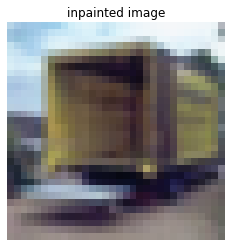

In [ ]:
# testing on single image
im = sample_images[0]
impainted_image = model.predict(im.reshape((1,)+im.shape))
plt.imshow(impainted_image.reshape(impainted_image.shape[1:]))
plt.title('inpainted image')
plt.axis('off')

Image index: 15
SSIM 15  tf.Tensor(0.97516066, shape=(), dtype=float32)
PSNR 15  tf.Tensor(31.45808, shape=(), dtype=float32)

Image index: 22
SSIM 22  tf.Tensor(0.9483724, shape=(), dtype=float32)
PSNR 22  tf.Tensor(31.740452, shape=(), dtype=float32)

Image index: 30
SSIM 30  tf.Tensor(0.93704134, shape=(), dtype=float32)
PSNR 30  tf.Tensor(28.176117, shape=(), dtype=float32)

Image index: 8
SSIM 8  tf.Tensor(0.9146208, shape=(), dtype=float32)
PSNR 8  tf.Tensor(27.984766, shape=(), dtype=float32)

Image index: 15
SSIM 15  tf.Tensor(0.9976762, shape=(), dtype=float32)
PSNR 15  tf.Tensor(33.959827, shape=(), dtype=float32)

Image index: 24
SSIM 24  tf.Tensor(0.9234803, shape=(), dtype=float32)
PSNR 24  tf.Tensor(26.037994, shape=(), dtype=float32)

Image index: 11
SSIM 11  tf.Tensor(0.928658, shape=(), dtype=float32)
PSNR 11  tf.Tensor(28.207647, shape=(), dtype=float32)

Image index: 23
SSIM 23  tf.Tensor(0.88775426, shape=(), dtype=float32)
PSNR 23  tf.Tensor(24.997147, shape=(), dt

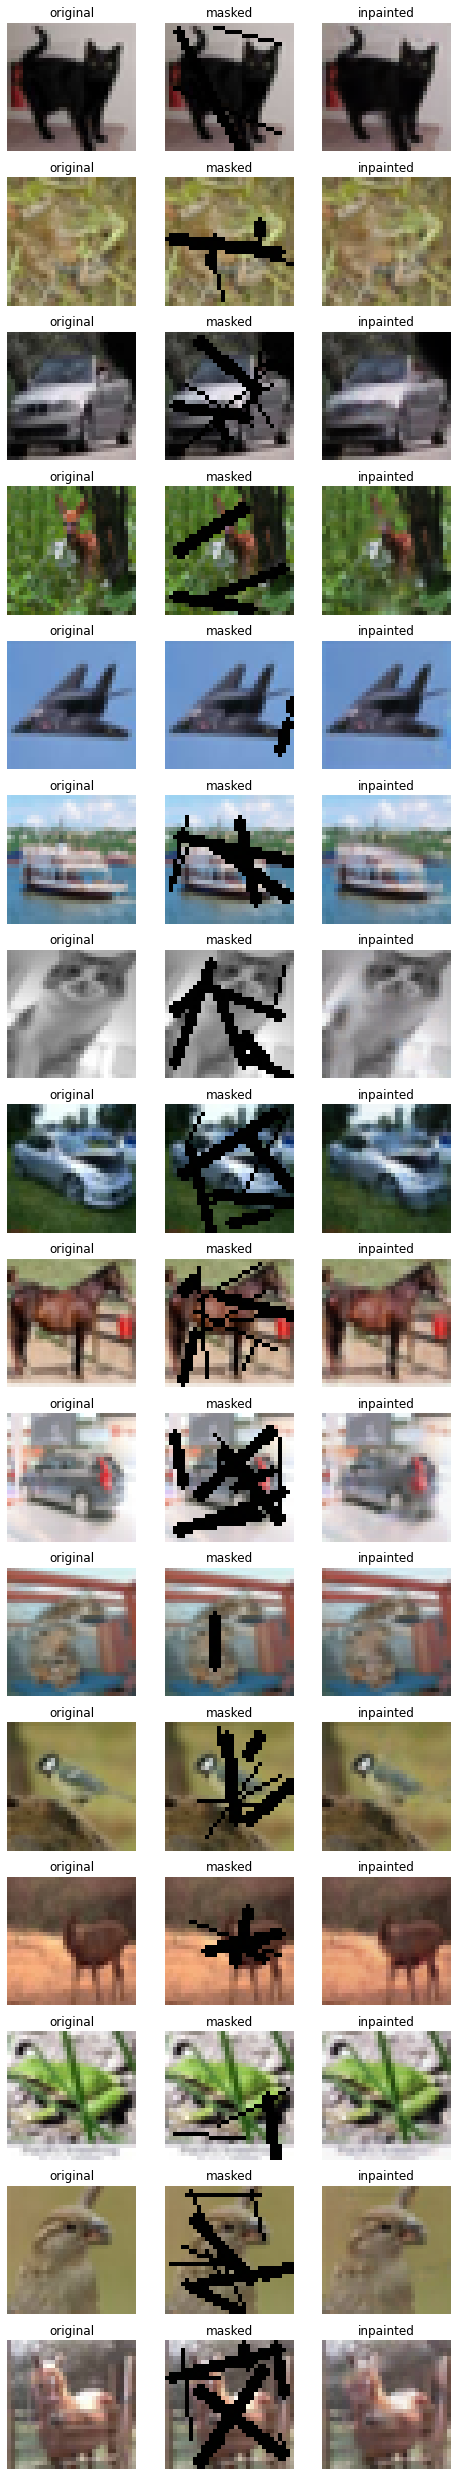

In [ ]:
# testing on random images

rows = 16
index = np.random.randint(0, len(testgen), rows)

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(8, 45))

for i, index in enumerate(index):
  
  sample_images, sample_labels = traingen[index]
  image_index = np.random.randint(0, len(sample_images)-1, 1)[0]
  
  inpainted_image = model.predict(sample_images[image_index].reshape((1,)+sample_images[image_index].shape))

  print("Image index:", image_index)

  # calculating SSIM
  ssim=tf.reduce_mean(tf.image.ssim(sample_labels[image_index].astype("double"),inpainted_image.reshape(inpainted_image.shape[1:]).astype("double"),2.0))
  txt = "SSIM {price:} "
  print(txt.format(price = image_index),ssim)
  
  # calculating PSNR
  psnr=(tf.image.psnr(sample_labels[image_index].astype("double"),inpainted_image.reshape(inpainted_image.shape[1:]).astype("double"), 1))
  txt = "PSNR {price:} "
  print(txt.format(price = image_index),psnr)

  print("")

  ax[i][0].imshow(sample_labels[image_index])
  ax[i][0].set_title('original')
  ax[i][0].axis('off')

  ax[i][1].imshow(sample_images[image_index])
  ax[i][1].set_title('masked')
  ax[i][1].axis('off')

  ax[i][2].imshow(inpainted_image.reshape(inpainted_image.shape[1:]))
  ax[i][2].set_title('inpainted')
  ax[i][2].axis('off')

plt.show()

### Creating square mask



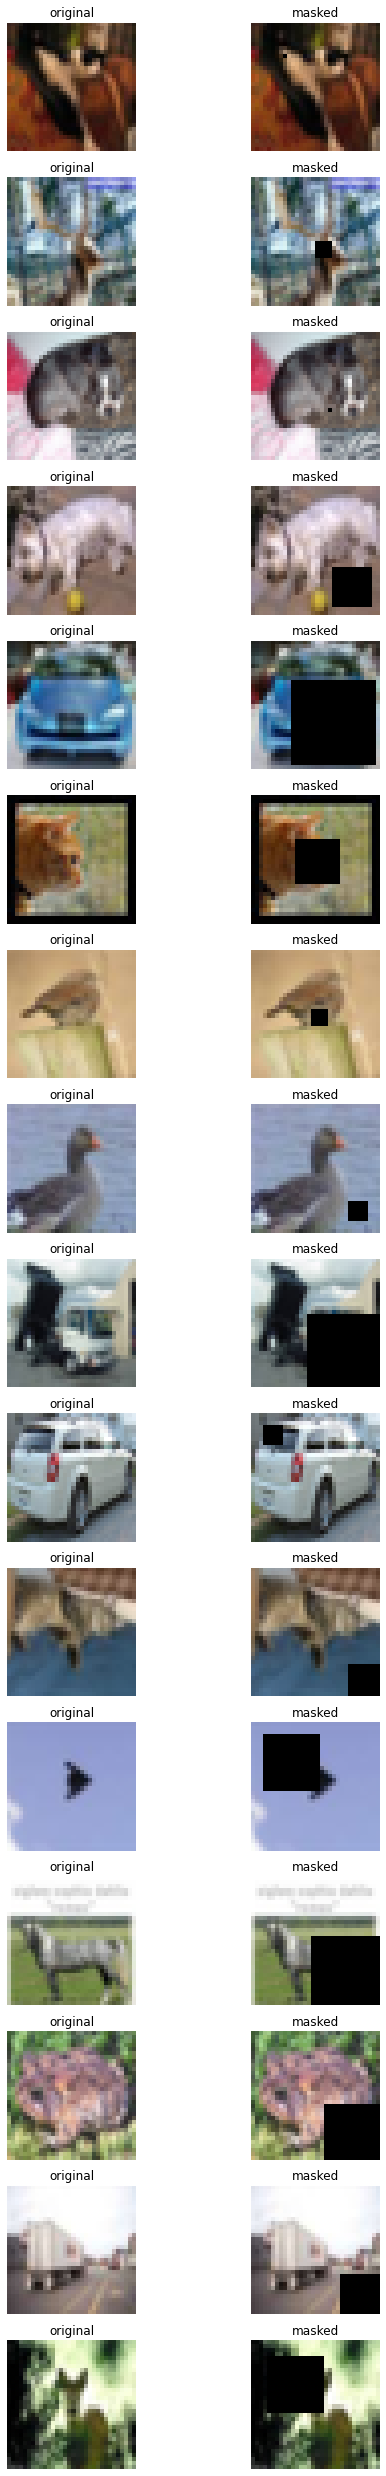

In [ ]:
class GenerateSquareMask(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.y = y
      self.X = X
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle == True:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      for i, idx in enumerate(idxs):
        tmp_image = self.X[idx].copy()

        # creating mask
        mask_square = np.full(tmp_image.shape, 255, np.uint8)
        # Get random x and y starting coordinate parameters
        x = y = np.random.randint(1, 25)
        # Get random width and height parameters
        w = h = np.random.randint(1, 25)
        # Creating the square mask for the random lengths and widths 
        mask_square[y:y+h, x:x+w] = 0

        # Perforn bitwise and operation to mak the image
        masked_image = cv2.bitwise_and(tmp_image, mask_square)

        # Normalizing data
        X_batch[i,] = masked_image/255
        y_batch[i] = self.y[idx]/255
        
      return X_batch, y_batch

traingen = GenerateSquareMask(x_train, x_train)
testgen = GenerateSquareMask(x_test, x_test)

# display images
rows = 16
index = np.random.randint(0, len(traingen), rows)

fig, ax = plt.subplots(nrows=16, ncols=2, figsize=(8,45))

for i, index in enumerate(index):
  
  sample_images, sample_labels = traingen[index]
  image_index = np.random.randint(0, len(sample_images)-1, 1)[0]
  
  ax[i][0].imshow(sample_labels[image_index])
  ax[i][0].set_title('original')
  ax[i][0].axis('off')
  
  ax[i][1].imshow(sample_images[image_index])
  ax[i][1].set_title('masked')
  ax[i][1].axis('off')

plt.show()

In [ ]:
# defining SSIM metric function
def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

# compiling model
keras.backend.clear_session()
model = inpainting_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[ssim])

In [ ]:
# training model
EPOCHS = 10
model.fit(traingen, validation_data=testgen, 
          epochs=EPOCHS, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/10
1562/1562 [==============================] - 40s 26ms/step - loss: 0.0041 - ssim: 0.8802 - val_loss: 0.0041 - val_ssim: 0.8807
Epoch 2/10
1562/1562 [==============================] - 40s 25ms/step - loss: 0.0040 - ssim: 0.8812 - val_loss: 0.0042 - val_ssim: 0.8804
Epoch 3/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.0039 - ssim: 0.8828 - val_loss: 0.0039 - val_ssim: 0.8838
Epoch 4/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.0039 - ssim: 0.8833 - val_loss: 0.0040 - val_ssim: 0.8832
Epoch 5/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.0038 - ssim: 0.8840 - val_loss: 0.0038 - val_ssim: 0.8848
Epoch 6/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.0038 - ssim: 0.8848 - val_loss: 0.0039 - val_ssim: 0.8844
Epoch 7/10
1562/1562 [==============================] - 39s 25ms/step - loss: 0.0038 - ssim: 0.8854 - val_loss: 0.0038 - val_ssim: 0.8854
Epoch 8/10
1562/1562 [============

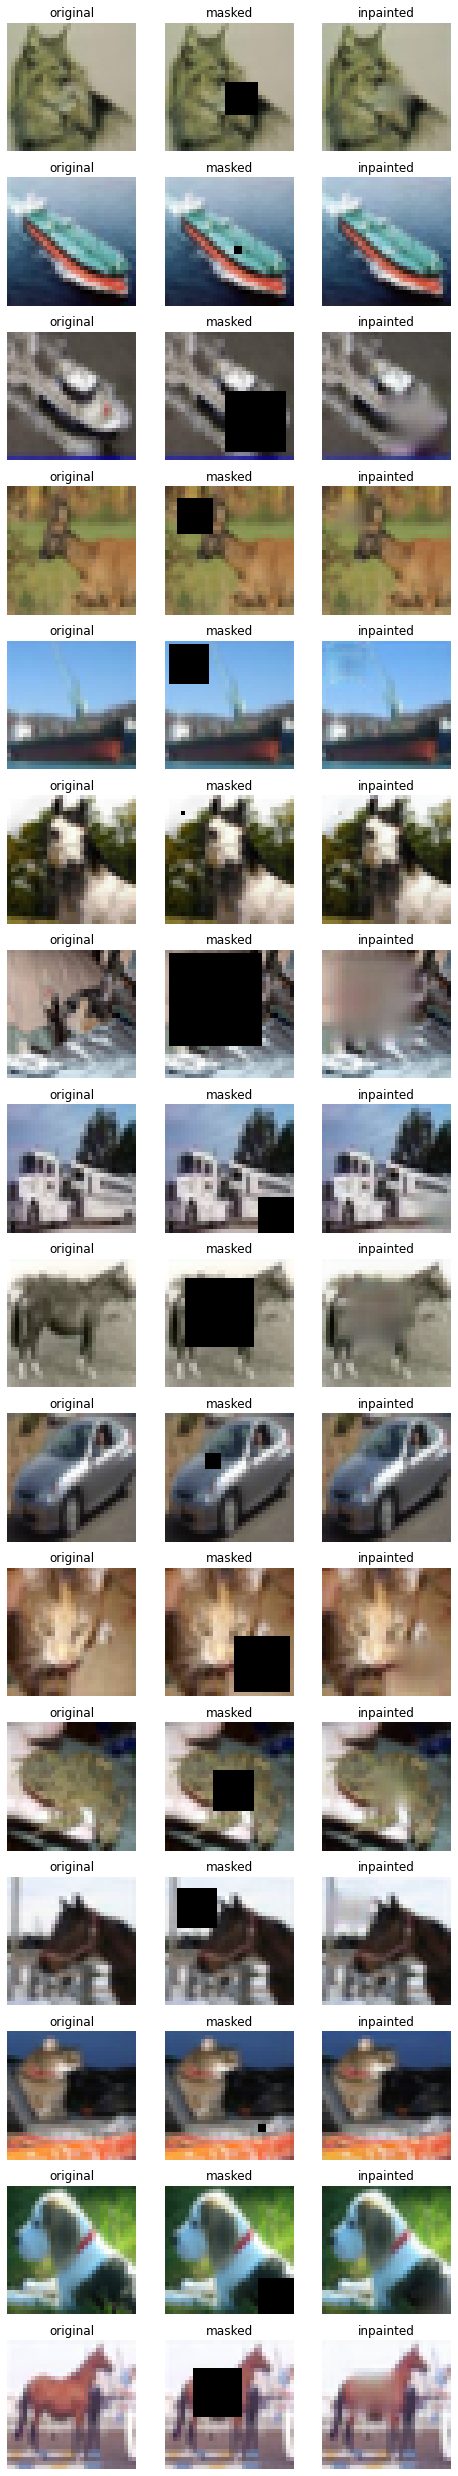

In [ ]:
# testing
rows = 16
index = np.random.randint(0, len(testgen), rows)

fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(8, 45))

for i, index in enumerate(index):
  
  sample_images, sample_labels = traingen[index]
  image_index = np.random.randint(0, len(sample_images)-1, 1)[0]
  
  inpainted_image = model.predict(sample_images[image_index].reshape((1,)+sample_images[image_index].shape))
  
  ax[i][0].imshow(sample_labels[image_index])
  ax[i][0].set_title('original')
  ax[i][0].axis('off')

  ax[i][1].imshow(sample_images[image_index])
  ax[i][1].set_title('masked')
  ax[i][1].axis('off')

  ax[i][2].imshow(inpainted_image.reshape(inpainted_image.shape[1:]))
  ax[i][2].set_title('inpainted')
  ax[i][2].axis('off')

plt.show()